<a href="https://colab.research.google.com/github/BondaiKa/lane_line_recognition/blob/data-formater/Frame_fix_resolution_3_output_lane_line_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import os
from google.colab import drive
import numpy as np
import glob
import json

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from typing import Tuple, List, Dict, Iterable
import math
from typing import Optional
import random
from pathlib import Path
import h5py

from typing import NamedTuple, Tuple, List,Dict, Union

%matplotlib inline
import logging
from google.colab.patches import cv2_imshow


In [96]:
log = logging.getLogger(__name__)

In [97]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
%%capture
!unrar x -Y "/content/drive/My Drive/Ilmenau/dataset.rar" "/tmp/"

In [129]:
MODEL_NAME = 'fixed_coordinate_own_cnn_lane_line_recognition'

INPUT_SHAPE = (384, 384, 1)
BATCH_SIZE = 8
AMOUNT_OF_FRAMES = 10000
VALIDATION_SPLIT = 0.2
MAX_LINES_PER_FRAME = 2
MAX_NUM_POINTS =  91
NUM_TYPE_OF_LINES = 4

In [100]:
BASE_DIR = "/tmp/dataset/VIL100/"
IMAGE_PATH = BASE_DIR + "JPEGImages/"
JSON_PATH = BASE_DIR + "Json/"
JSON_HDF5_DATASET_PATH = BASE_DIR + "hdf5/"


print(IMAGE_PATH)
print(JSON_PATH)
print(JSON_HDF5_DATASET_PATH)

/tmp/dataset/VIL100/JPEGImages/
/tmp/dataset/VIL100/Json/
/tmp/dataset/VIL100/hdf5/


In [101]:
initial_frame_glob_path = IMAGE_PATH+'/*/*.jpg'
json_glob_path = JSON_PATH + '/*/*.json'

images = glob.glob(IMAGE_PATH+'/*/*.jpg')
json_files = glob.glob(JSON_PATH+'/*/*.json')

In [102]:
class VIL100HDF5:
    ROOT_FRAME_FOLDER = 'JPEGImages_hdf5'
    ROOT_FOLDER = 'hdf5'
    GROUP_NAME = 'frame_polylines_labels'
    POLYLINES_DATASET_NAME = 'polylines'
    LABELS_DATASET_NAME = 'labels'
    FRAME_DATASET_NAME='frame'


LANE_ID_FULL_LIST = set(range(1, 3))


class Vil100Json:
    ANNOTATIONS = 'annotations'
    #Annotations
    ATTRIBUTE = 'attribute'
    LANE = 'lane'
    LANE_ID = 'lane_id'
    POINTS = 'points'

    INFO = 'info'
    #Info
    IMAGE_PATH = 'image_path'
    HEIGHT = 'height'
    WIDTH = 'width'


class VIL100Attribute:
    """Lane Attribute id (type lane) in jsons"""
    SINGLE_WHITE_SOLID = 1
    SINGLE_WHITE_DOTTED = 2
    SINGLE_YELLOW_SOLID = 3
    SINGLE_YELLOW_DOTTED = 4
    DOUBLE_WHITE_SOLID = 5
    DOUBLE_YELLOW_SOLID = 7
    DOUBLE_YELLOW_DOTTED = 8
    DOUBLE_WHITE_SOLID_DOTTED = 9
    DOUBLE_WHITE_DOTTED_SOLID = 10
    DOUBLE_SOLID_WHITE_AND_YELLOW = 13


class LineType:
    """Type lane in our task"""
    NO_LINE = 0
    SINGLE_WHITE_SOLID = 1
    SINGLE_WHITE_DOTTED = 2
    DOUBLE_WHITE_SOLID = 3
    ALL_LINES = {NO_LINE, SINGLE_WHITE_SOLID, SINGLE_WHITE_DOTTED, DOUBLE_WHITE_SOLID}


VIL_100_colour_line = {
    LineType.SINGLE_WHITE_SOLID: (255, 0, 0),  # single white solid
    LineType.SINGLE_WHITE_DOTTED: (0, 255, 0),  # single white dotted
    LineType.DOUBLE_WHITE_SOLID: (255, 125, 0),  # single yellow solid
    # 4: (255, 255, 0),  # single yellow dotted
    # 5: (255, 0, 0),  # double white solid
    # 6: (255, 125, 0),  # double yellow solid
    # 7: (255, 255, 0),  # double yellow dotted
    # 8: (255, 0, 0),  # double white solid dotted
    # 9: (255, 0, 0),  # double white dotted solid
    # 10: (255, 0, 0),  # double solid white and yellow
}


def get_valid_attribute(attr: int) -> int:
    """Change attribute from VIL100 dataset to normal number without missings"""
    _VIL_100_attributes = {
        LineType.NO_LINE: LineType.NO_LINE,
        VIL100Attribute.SINGLE_WHITE_SOLID: LineType.SINGLE_WHITE_SOLID,
        VIL100Attribute.SINGLE_WHITE_DOTTED: LineType.SINGLE_WHITE_DOTTED,
        VIL100Attribute.SINGLE_YELLOW_SOLID: LineType.SINGLE_WHITE_SOLID,
        VIL100Attribute.SINGLE_YELLOW_DOTTED: LineType.SINGLE_WHITE_DOTTED,
        VIL100Attribute.DOUBLE_WHITE_SOLID: LineType.DOUBLE_WHITE_SOLID,
        VIL100Attribute.DOUBLE_YELLOW_SOLID: LineType.DOUBLE_WHITE_SOLID,
        VIL100Attribute.DOUBLE_YELLOW_DOTTED: LineType.DOUBLE_WHITE_SOLID,
        VIL100Attribute.DOUBLE_WHITE_SOLID_DOTTED: LineType.DOUBLE_WHITE_SOLID,
        VIL100Attribute.DOUBLE_WHITE_DOTTED_SOLID: LineType.DOUBLE_WHITE_SOLID,
        VIL100Attribute.DOUBLE_SOLID_WHITE_AND_YELLOW: LineType.DOUBLE_WHITE_SOLID,
    }
    return _VIL_100_attributes.get(attr, LineType.NO_LINE)


def get_colour_from_one_hot_vector(vector: np.ndarray) -> Tuple[int, int, int]:
    """Get colour from one hot vector"""
    return VIL_100_colour_line.get(int(np.argmax(vector, axis=1)), None)


def one_hot_list_encoder(target_class_idx: int, num_classes: int) -> np.ndarray:
    """One-hot list encoder"""
    target_vector = np.zeros(num_classes)
    target_vector[target_class_idx] = 1
    return target_vector

In [103]:
class JsonReviewer:
    def __init__(self, json_glob_path: str, frame_dataset_path: str):
        self.json_glob_path = sorted(glob.glob(json_glob_path))
        self.frame_dataset_path = frame_dataset_path

    @staticmethod
    def fix_json_file(json_file: Dict[str, Union[str, int]], frame_real_height: int, frame_real_width: int,
                      frame_path: str) -> Dict[str, Union[str, int]]:
        if json_file[Vil100Json.INFO][Vil100Json.HEIGHT] != frame_real_height or \
                json_file[Vil100Json.INFO][Vil100Json.WIDTH] != frame_real_width:
            log.debug(f'Different resolution! File name: `{frame_path}`.')
            json_file[Vil100Json.INFO][Vil100Json.HEIGHT] = frame_real_height
            json_file[Vil100Json.INFO][Vil100Json.WIDTH] = frame_real_width

        return json_file

    def exec(self):
        for json_file_path in self.json_glob_path:
            # TODO: check open format
            with open(json_file_path, 'r+') as f:
                json_file = json.load(f)
                image_path = json_file[Vil100Json.INFO][Vil100Json.IMAGE_PATH]
                full_path = self.frame_dataset_path + '/' + image_path
                frame = cv2.imread(full_path)
                height, width = frame.shape[0], frame.shape[1]

                json_file = self.fix_json_file(json_file, height, width, image_path)

                f.seek(0)
                json.dump(json_file, f)
                f.truncate()


In [104]:
class VILLJsonConverter:

    def __init__(self,
                 max_lines_per_frame: int,
                 max_num_points: int,
                 num_type_of_lines: int,
                 json_glob_path: str,
                 final_shape: Tuple[int, int],
                 frame_dataset_path: str,
                 ):

        self.max_lines_per_frame = max_lines_per_frame
        self.max_num_points = max_num_points
        self.num_type_of_lines = num_type_of_lines
        self.json_files = sorted(glob.glob(json_glob_path))
        self.files_count = len(self.json_files)
        self.frame_dataset_path = frame_dataset_path
        self.final_shape = final_shape

    def __rescale_coordinates(self, row: np.ndarray, initial_width: int, initial_height: int) -> np.ndarray:
        return int(row[0] / initial_width * self.final_shape[0]), \
               int(row[1] / initial_height * self.final_shape[1])

    def __rescale_polylines(self, polylines: np.ndarray, initial_width: int, initial_height: int) -> np.ndarray:
        """Rescale coordinates due to new frame resolution"""
        return np.apply_along_axis(self.__rescale_coordinates, axis=1, arr=polylines,
                                   initial_width=initial_width,
                                   initial_height=initial_height
                                   )

    def __get_polyline_with_label(self, lane: dict, initial_width: int, initial_height: int) -> Tuple[
        np.ndarray, np.ndarray]:
        """Get array from points list"""
        points = np.array(
            lane[Vil100Json.POINTS])
        points = self.__rescale_polylines(points, initial_width=initial_width, initial_height=initial_height).flatten()
        points = np.pad(points, pad_width=(0, self.max_num_points * 2 - points.shape[0]),
                        mode='constant', constant_values=(-100,))
        # TODO @Karim: remember below `label.get(label)` is index 1,2,3,4
        label = get_valid_attribute(lane.get(Vil100Json.ATTRIBUTE, LineType.NO_LINE))
        labels = one_hot_list_encoder(label, self.num_type_of_lines)
        return points, labels

    def __get_polyline_and_label_from_file(self, json_path: str) -> Tuple[np.ndarray, np.ndarray]:
        """
        Retrieve from json file polylines and labels and format to nn input

        :param json_path: json file path
        :return: frame and tuple of labels
        """
        with open(json_path) as f:
            json_file: Dict[str, Union[int, dict]] = json.load(f)
            image_path = json_file[Vil100Json.INFO][Vil100Json.IMAGE_PATH]
            full_path = self.frame_dataset_path + '/' + image_path
            frame = cv2.imread(full_path)
            height, width = frame.shape[0], frame.shape[1]
            json_file = JsonReviewer.fix_json_file(
                json_file=json_file,
                frame_real_height=height,
                frame_real_width=width,
                frame_path=image_path
            )

            width = json_file[Vil100Json.INFO][Vil100Json.WIDTH]
            height = json_file[Vil100Json.INFO][Vil100Json.HEIGHT]

            lanes: Lane_type = json_file[Vil100Json.ANNOTATIONS][Vil100Json.LANE]
            lanes = sorted(lanes, key=lambda lane: lane[Vil100Json.LANE_ID])

            if lanes:
                polylines, labels = np.array([]), np.array([])
                # TODO @Karim: check another params in json files like "occlusion"
                exist_lane = [x[Vil100Json.LANE_ID] for x in lanes]
                missed_lane = LANE_ID_FULL_LIST - set(exist_lane)

                for lane_id in range(1, self.max_lines_per_frame + 1):
                    if lane_id in missed_lane:
                        points = np.zeros(shape=(self.max_num_points * 2))
                        label = one_hot_list_encoder(LineType.NO_LINE, self.num_type_of_lines)
                    else:
                        points, label = self.__get_polyline_with_label(
                            lane=lanes[exist_lane.index(lane_id)],
                            initial_width=width,
                            initial_height=height
                        )

                    if lane_id % 2 == 0:
                        polylines = np.append(polylines, points)
                        labels = np.append(labels, label)
                    else:
                        polylines = np.insert(polylines, 0, points)
                        labels = np.insert(labels, 0, label)

                return polylines, labels
            else:
                empty_label = one_hot_list_encoder(LineType.NO_LINE, self.num_type_of_lines)
                polylines_empty_shape = self.max_lines_per_frame * self.max_num_points * 2
                return np.zeros(shape=polylines_empty_shape), np.array(
                    [empty_label for x in range(self.max_lines_per_frame)]).flatten()

    def exec(self) -> None:
        """Convert and save json files to new hdf5 files"""
        for json_file_path in self.json_files:
            polylines, labels = self.__get_polyline_and_label_from_file(json_file_path)

            full_path_list = json_file_path.split('/')
            full_path_list[-3] = VIL100HDF5.ROOT_FOLDER
            root_path = full_path_list[:-1]
            frame_name = full_path_list[-1]

            Path(f"{'/'.join(root_path)}").mkdir(parents=True, exist_ok=True)

            with h5py.File(f"{'/'.join(root_path)}/{frame_name}.hdf5", "w") as f:
                grp = f.create_group(VIL100HDF5.GROUP_NAME)
                grp.create_dataset(VIL100HDF5.POLYLINES_DATASET_NAME, data=polylines, dtype='int32')
                grp.create_dataset(VIL100HDF5.LABELS_DATASET_NAME, data=labels, dtype='int32')



In [105]:
print(INPUT_SHAPE)

(384, 384, 1)


In [106]:
converter = VILLJsonConverter(
        max_lines_per_frame=MAX_LINES_PER_FRAME,
        max_num_points=MAX_NUM_POINTS,
        num_type_of_lines=NUM_TYPE_OF_LINES,
        json_glob_path=json_glob_path,
        final_shape=(INPUT_SHAPE[0],INPUT_SHAPE[1]),
        frame_dataset_path=IMAGE_PATH
    )

In [107]:
converter.exec()

In [108]:
!rm -rf /tmp/dataset/VIL100/Json

In [130]:
class SimpleFrameGenerator(Sequence):
    """Sequence of frames generator

    Usage for training NN that could process independent
    frames without context window etc
    """

    def __init__(self,
                 num_type_of_lines=4,
                 max_num_points=91,
                 max_lines_per_frame=2,
                 rescale=1 / 255.,  # TODO @Karim: include and use later
                 batch_size: int = 8,
                 target_shape: Tuple[int, int] = (640, 480),
                 shuffle: bool = False,
                 nb_channel: int = 3,  # TODO: Use rgb later
                 files: Optional[List[str]] = None,
                 json_files: Optional[List[str]] = None):
        """
        :param subset: training or validation data
        :param max_lines_per_frame: maxinum number of lines per frame
        :param max_num_points: maximum number of points un one polyline
        :param num_type_of_lines: number of possible lines on road
        :param rescale:
        :param batch_size: batch size of the dataset
        :param target_shape: final size for NN input
        :param shuffle: shuffle flag of frames sequences
        :param split: split dataset to train/test
        :param nb_channel: grayscaled or RGB frames
        :param frame_glob_path: glob pattern of frames
        :param json_glob_path: glob pattern path of jsons
        """
        self.max_lines_per_frame = max_lines_per_frame
        self.max_num_points = max_num_points
        self.num_type_of_lines = num_type_of_lines
        self.rescale = rescale
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.target_shape = target_shape
        self.nb_channel = nb_channel
        self.files = files
        self.json_files = json_files
        self.files_count = len(self.files)

        if shuffle:
            temp = list(zip(self.files, self.json_files))
            random.shuffle(temp)
            self.files, self.json_files = zip(*temp)

    def __len__(self):
        return math.ceil(self.files_count / self.batch_size)

    def __get_polyline_and_label_from_file(self, json_path: str) -> Tuple[np.ndarray, np.ndarray]:
        """
        Get from hdf5 all polylines and their labels
        :param json_path: path of json file
        :return: polylines with labels
        """
        file = h5py.File(json_path, 'r')
        group = file.get(VIL100HDF5.GROUP_NAME)
        return group.get(VIL100HDF5.POLYLINES_DATASET_NAME), group.get(VIL100HDF5.LABELS_DATASET_NAME)

    def __get_frame_from_file(self, frame_path: str) -> np.ndarray:
        frame = tf.keras.utils.load_img(frame_path,
                                            color_mode='grayscale',
                                            target_size=(self.target_shape[1], self.target_shape[0])
                                            )
        frame = tf.keras.preprocessing.image.img_to_array(frame)
        frame = frame * self.rescale
        frame = np.expand_dims(frame,0)
        return frame

    def __getitem__(self, idx) -> Tuple[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        batch_frames_path = self.files[idx * self.batch_size:
                                       (idx + 1) * self.batch_size]
        batch_json_path = self.json_files[idx * self.batch_size:
                                          (idx + 1) * self.batch_size]

        polylines_list, labels_list = self.__get_polyline_and_label_from_file(batch_json_path[0])
        frame_list = self.__get_frame_from_file(batch_frames_path[0])

        for _frame, _json in zip(batch_frames_path[1:], batch_json_path[1:]):
            polylines, labels = self.__get_polyline_and_label_from_file(_json)
            polylines_list = np.vstack((polylines_list, polylines))
            labels_list = np.vstack((labels_list, labels))

            frame = self.__get_frame_from_file(_frame)
            frame_list = np.vstack((frame_list, frame))

        return (frame_list), (polylines_list,) + tuple(np.hsplit(labels_list, self.max_lines_per_frame))


class SimpleFrameDataGen:
    TRAINING = 'training'
    VALIDATION = 'validation'

    __reverse_dataset_type = {
        TRAINING: VALIDATION,
        VALIDATION: TRAINING
    }
    __dataset = {}

    def __init__(self,
                 rescale=1 / 255.,
                 validation_split: Optional[float] = None,
                 frame_glob_path: str = "",
                 json_hdf5_glob_path: str = ""):
        """
        :param validation_split: split for train/validation sets
        :param rescale:
        :param frame_glob_path: glob pattern of frames
        :param json_glob_path: glob pattern path of jsons
        """
        self.rescale = rescale
        self.validation_split = validation_split

        self.__frame_glob_path = frame_glob_path
        self.__json_hdf5_glob_path = json_hdf5_glob_path

    def flow_from_directory(self, subset: str = TRAINING,
                            shuffle: bool = True, number_files: int = 2000, *args, **kwargs) -> SimpleFrameGenerator:
        """
        Get generator for subset
        :param subset: 'training' or 'validation'
        :param shuffle: flag for shuffling
        :param number_files: rectrict max number of files from dataset
        :param args: args for specific dataset
        :param kwargs: kwargs for specific dataset
        :return: Specific generator for specific subset
        """

        files = sorted(glob.glob(self.__frame_glob_path))
        log.info(f"Number of files in dataset: {len(files)}. Using in training/validation: {number_files}")
        files = files[:number_files]

        json_files = sorted(glob.glob(self.__json_hdf5_glob_path))[:number_files]
        files_count = len(files)
        json_files_count = len(json_files)

        if files_count != json_files_count:
            log.error(f"Dataset files error"
                      f"Number of frames: ({files_count}). "
                      f"Number of jsons({json_files_count}")
            raise FileNotFoundError(
                f"Numbers of frames and jsons are not equal!")

        if not self.__reverse_dataset_type.get(subset):
            log.error(f'Wrong subset value: "{subset}"')
            raise ValueError(f'Wrong type of subset - {subset}. '
                             f'Available types: {self.__reverse_dataset_type.keys()}')

        if self.validation_split and 0.0 < self.validation_split < 1.0:
            split = int(files_count * (1 - self.validation_split))
            if subset == self.TRAINING:
                files = files[:split]
                json_files = json_files[:split]
            else:
                files = files[split:]
                json_files = json_files[split:]

        return SimpleFrameGenerator(rescale=self.rescale,
                                    files=files,
                                    shuffle=shuffle,
                                    json_files=json_files,
                                    *args, **kwargs)

In [131]:
data_gen = SimpleFrameDataGen(
    validation_split=VALIDATION_SPLIT, 
    frame_glob_path=initial_frame_glob_path, 
    json_hdf5_glob_path=JSON_HDF5_DATASET_PATH+'/*/*.hdf5',
)

train_generator = data_gen.flow_from_directory(
  subset='training', shuffle=True, batch_size = BATCH_SIZE, 
  number_files=AMOUNT_OF_FRAMES, max_lines_per_frame=MAX_LINES_PER_FRAME,
  max_num_points = MAX_NUM_POINTS, num_type_of_lines = NUM_TYPE_OF_LINES,
  target_shape=INPUT_SHAPE,
)

validation_generator = data_gen.flow_from_directory(
  subset='validation', shuffle=True, batch_size = BATCH_SIZE, 
  number_files=AMOUNT_OF_FRAMES, max_lines_per_frame=MAX_LINES_PER_FRAME,
  max_num_points = MAX_NUM_POINTS, num_type_of_lines = NUM_TYPE_OF_LINES,
  target_shape=INPUT_SHAPE,
)


In [132]:
def test_generator(generator:SimpleFrameGenerator, draw_line=False)->None:
  """Test frame and labels on generator"""
  original_frames, original_labels = generator[1]
  original_frame = original_frames[0]
  polylines, original_label_1, original_label_2 = original_labels[0][0],original_labels[1][0],original_labels[2][0]
  # print(polylines)

  if draw_line:
    original_frame = cv2.polylines(original_frame, np.int32(polylines).reshape((-1, 1, 2)), 1, color=(255,0,255), thickness=5)
  
  cv2_imshow(original_frame * 255)
  print(original_frame.shape)


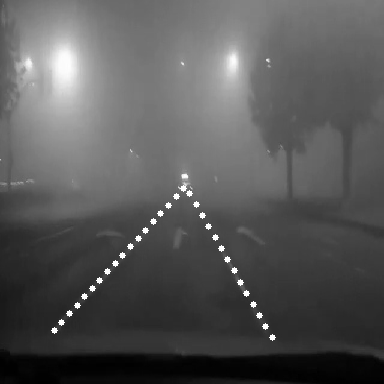

(384, 384, 1)


In [133]:
test_generator(validation_generator,draw_line=True)

In [134]:
from tensorflow.keras import layers, Model


def build_model(polyline_output_shape:int ,label_output_shape:int, input_shape:Tuple[int,int,int], model_name:str):

    input_img = layers.Input(shape=input_shape)

    # First block
    layer = layers.Conv2D(256, (3, 3), activation='relu',use_bias=False)(input_img)
    layer = layers.BatchNormalization()(layer)
    layer = layers.MaxPooling2D()(layer)

    # Second block
    layer = layers.Conv2D(256, (3, 3), activation='relu',use_bias=False)(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.MaxPooling2D()(layer)

    # Third block
    layer = layers.Conv2D(128, (3, 3), activation='relu',use_bias=False)(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.MaxPooling2D()(layer)

    # Fourth block
    layer = layers.Conv2D(64, (3, 3), activation='relu',use_bias=False)(layer)
    layer = layers.BatchNormalization()(layer)

    # GlobalMaxPool
    layer = layers.GlobalMaxPool2D()(layer)
    
    # polyline part
    
    z = tf.keras.layers.Dense(units=256, activation='relu')(layer)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(.2)(z)

    z = tf.keras.layers.Dense(units=128,activation='relu')(z)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(.2)(z)

    # label common part
    dense_label = tf.keras.layers.Dense(units=512, activation='relu')(layer)
    batch_norm = layers.BatchNormalization()(dense_label)
    dropout_label = layers.Dropout(.2)(batch_norm)

    # lane 1 part
    x = tf.keras.layers.Dense(units=128, activation='relu')(dropout_label)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(.2)(x)

    x = tf.keras.layers.Dense(units=64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(.2)(x)
   
    # lane 2 part
    
    y = tf.keras.layers.Dense(units=128, activation='relu')(dropout_label)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(.2)(y)

    
    y = tf.keras.layers.Dense(units=64, activation='relu')(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(.2)(y)

    # output
    polyline_output = layers.Dense(polyline_output_shape,name='polyline_output')(z)
    label_output_1 = layers.Dense(label_output_shape, activation='softmax', name='label_output_1')(x)
    label_output_2 = layers.Dense(label_output_shape, activation='softmax', name='label_output_2')(y)

    model = Model(input_img, outputs=[
        polyline_output,
        label_output_1,
        label_output_2,
      ], name = model_name
    )

    return model

In [135]:
model_name = MODEL_NAME
logdir = f"logs/{model_name}"
checkpoint_filepath = f"/model/{model_name}"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stop_polyline_callback = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_polyline_output_loss')

reduce_lr_callback_depends_on_polyline_loss = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_polyline_output_loss', factor=0.8, patience=2, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0.00001
)
reduce_lr_callback_depends_on_label_1_loss = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_label_output_1_loss', factor=0.8, patience=2, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0.00001
)
reduce_lr_callback_depends_on_label_2_loss = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_label_output_2_loss', factor=0.8, patience=2, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0.00001
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_polyline_output_loss',
    mode='max',
    save_best_only=True)

In [136]:
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self,train_generator, validation_generator,*args,**kwargs):
    super().__init__(*args,**kwargs)
    self.train_generator = train_generator
    self.validation_generator = validation_generator

  def __filter_coordination_for_resolution(self, polyline: np.ndarray) -> np.ndarray:
    valid = ((polyline[:, 0] > 0) & (polyline[:, 1] > 0)
              & (polyline[:, 0] < 384) & (polyline[:, 1] < 384))
    return polyline[valid]

  def __filter_coordinates(self, list_of_polylines: List[np.ndarray]) -> np.ndarray:
    """Remove empty points and coordinates x or y, that is less than 0"""
    list_of_polylines = list(map(lambda x: x.reshape(-1, 2), list_of_polylines))
    return list(map(lambda polyline: self.__filter_coordination_for_resolution(polyline),
                    list_of_polylines))  

  def test_model(self, generator):
    original_frames, original_labels = generator[0]
    original_frame = original_frames[0]
    original_polylines, original_label_1, original_label_2 = original_labels[0][0],original_labels[1][0],original_labels[2][0]

    original_frame = np.copy(original_frame)
    frame = np.expand_dims(original_frame,0)

    res = model.predict(frame.T)
    polylines,label_1,label_2 = res[0],res[1],res[2]
    polylines = np.hsplit(polylines, 2)
    polylines = self.__filter_coordinates(polylines)

    for points,color in zip(polylines, [(255,0,255),(0,255,255)]):
      original_frame = cv2.polylines(original_frame, np.int32(points).reshape((-1, 1, 2)), 1, color=color, thickness=5)
      original_frame = cv2.polylines(original_frame, np.int32(original_polylines).reshape((-1, 1, 2)), 1, color=color, thickness=2)


    cv2_imshow(original_frame * 255)

  def on_epoch_end(self, epoch, logs=None):
      print(f'Epoch {epoch}. Draw polylines on train generator...')
      self.test_model(self.train_generator)

      # print(f'Epoch {epoch}. Draw polylines on validation generator...')
      # self.test_model(self.validation_generator)
      # print('------')



In [137]:
model = build_model(
    polyline_output_shape=MAX_NUM_POINTS * 2 * MAX_LINES_PER_FRAME, 
    label_output_shape=NUM_TYPE_OF_LINES, 
    input_shape = INPUT_SHAPE,
    model_name = MODEL_NAME,
)
# print(model.summary())

In [138]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.01

model.compile(loss= {
      'polyline_output':tf.keras.losses.MeanSquaredError(),
      'label_output_1':tf.keras.losses.CategoricalCrossentropy(),
      'label_output_2':tf.keras.losses.CategoricalCrossentropy(),
    },
    optimizer=Adam(learning_rate=learning_rate),
    metrics={'polyline_output':tf.keras.metrics.MeanSquaredError(),
             'label_output_1':'accuracy',
             'label_output_2':'accuracy',
             },)

Epoch 1/2
Epoch 0. Draw polylines on train generator...


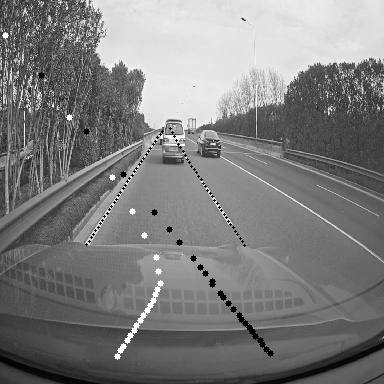

1000/1000 - 274s - loss: 3704.2458 - polyline_output_loss: 3702.8677 - label_output_1_loss: 0.6583 - label_output_2_loss: 0.7201 - polyline_output_mean_squared_error: 3702.8677 - label_output_1_accuracy: 0.6876 - label_output_2_accuracy: 0.6578 - val_loss: 4578.4941 - val_polyline_output_loss: 4574.0137 - val_label_output_1_loss: 2.5270 - val_label_output_2_loss: 1.9540 - val_polyline_output_mean_squared_error: 4574.0137 - val_label_output_1_accuracy: 0.3595 - val_label_output_2_accuracy: 0.6565 - lr: 0.0100 - 274s/epoch - 274ms/step
Epoch 2/2
Epoch 1. Draw polylines on train generator...


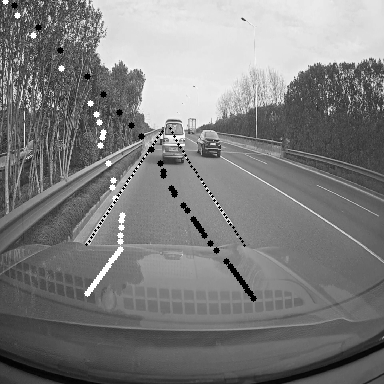

1000/1000 - 270s - loss: 2301.8406 - polyline_output_loss: 2300.6948 - label_output_1_loss: 0.5558 - label_output_2_loss: 0.5924 - polyline_output_mean_squared_error: 2300.6948 - label_output_1_accuracy: 0.7398 - label_output_2_accuracy: 0.7265 - val_loss: 4842.7925 - val_polyline_output_loss: 4838.4004 - val_label_output_1_loss: 2.1705 - val_label_output_2_loss: 2.2215 - val_polyline_output_mean_squared_error: 4838.4004 - val_label_output_1_accuracy: 0.4755 - val_label_output_2_accuracy: 0.5900 - lr: 0.0100 - 270s/epoch - 270ms/step


In [139]:
history = model.fit(train_generator,
                    epochs=2,
                    verbose=2,
                    validation_data=validation_generator,
                    callbacks=[
                        tensorboard_callback,
                        early_stop_polyline_callback,
                        reduce_lr_callback_depends_on_polyline_loss,
                        model_checkpoint_callback,
                        reduce_lr_callback_depends_on_label_1_loss,
                        reduce_lr_callback_depends_on_label_2_loss,
                        CustomCallback(train_generator=train_generator, validation_generator=validation_generator)
                      ],
                    )

In [140]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)

Epoch 1/10
Epoch 0. Draw polylines on train generator...


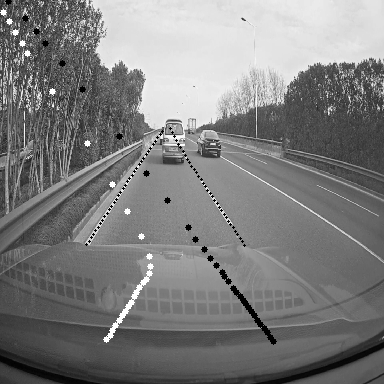

1000/1000 - 270s - loss: 2196.8147 - polyline_output_loss: 2195.8140 - label_output_1_loss: 0.4814 - label_output_2_loss: 0.5184 - polyline_output_mean_squared_error: 2195.8140 - label_output_1_accuracy: 0.7832 - label_output_2_accuracy: 0.7744 - val_loss: 6363.2261 - val_polyline_output_loss: 6360.0332 - val_label_output_1_loss: 1.7831 - val_label_output_2_loss: 1.4108 - val_polyline_output_mean_squared_error: 6360.0332 - val_label_output_1_accuracy: 0.4720 - val_label_output_2_accuracy: 0.5905 - lr: 0.0010 - 270s/epoch - 270ms/step
Epoch 2/10
Epoch 1. Draw polylines on train generator...


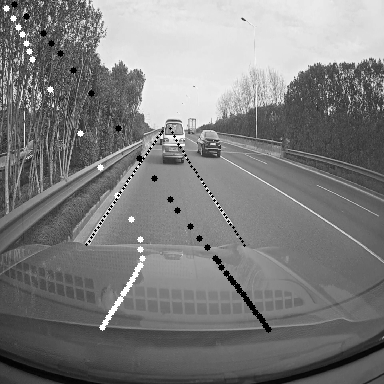

1000/1000 - 269s - loss: 2148.9500 - polyline_output_loss: 2148.0168 - label_output_1_loss: 0.4547 - label_output_2_loss: 0.4793 - polyline_output_mean_squared_error: 2148.0168 - label_output_1_accuracy: 0.8067 - label_output_2_accuracy: 0.7906 - val_loss: 8757.4434 - val_polyline_output_loss: 8754.1201 - val_label_output_1_loss: 1.8011 - val_label_output_2_loss: 1.5183 - val_polyline_output_mean_squared_error: 8754.1201 - val_label_output_1_accuracy: 0.4030 - val_label_output_2_accuracy: 0.4855 - lr: 0.0010 - 269s/epoch - 269ms/step
Epoch 3/10

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
Epoch 2. Draw polylines on train generator...


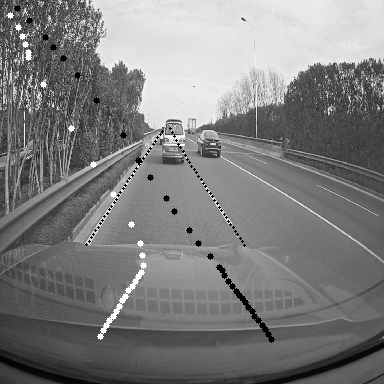

1000/1000 - 270s - loss: 2108.2341 - polyline_output_loss: 2107.3650 - label_output_1_loss: 0.4288 - label_output_2_loss: 0.4436 - polyline_output_mean_squared_error: 2107.3650 - label_output_1_accuracy: 0.8134 - label_output_2_accuracy: 0.8139 - val_loss: 5739.3882 - val_polyline_output_loss: 5732.1216 - val_label_output_1_loss: 2.9978 - val_label_output_2_loss: 4.2692 - val_polyline_output_mean_squared_error: 5732.1216 - val_label_output_1_accuracy: 0.4545 - val_label_output_2_accuracy: 0.5690 - lr: 8.0000e-04 - 270s/epoch - 270ms/step
Epoch 4/10
Epoch 3. Draw polylines on train generator...


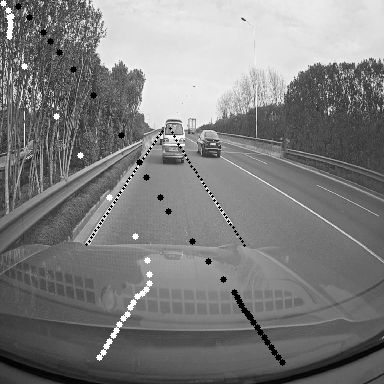

1000/1000 - 270s - loss: 2066.2275 - polyline_output_loss: 2065.4136 - label_output_1_loss: 0.4009 - label_output_2_loss: 0.4128 - polyline_output_mean_squared_error: 2065.4136 - label_output_1_accuracy: 0.8270 - label_output_2_accuracy: 0.8265 - val_loss: 7077.8848 - val_polyline_output_loss: 7072.3413 - val_label_output_1_loss: 3.2236 - val_label_output_2_loss: 2.3199 - val_polyline_output_mean_squared_error: 7072.3413 - val_label_output_1_accuracy: 0.4160 - val_label_output_2_accuracy: 0.5185 - lr: 6.4000e-04 - 270s/epoch - 270ms/step
Epoch 5/10

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.
Epoch 4. Draw polylines on train generator...


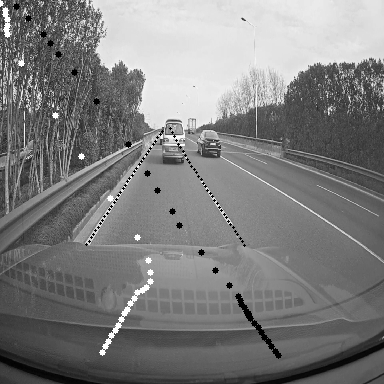

1000/1000 - 270s - loss: 2036.7408 - polyline_output_loss: 2035.9622 - label_output_1_loss: 0.3755 - label_output_2_loss: 0.4036 - polyline_output_mean_squared_error: 2035.9622 - label_output_1_accuracy: 0.8376 - label_output_2_accuracy: 0.8331 - val_loss: 6008.7773 - val_polyline_output_loss: 6003.5737 - val_label_output_1_loss: 3.2682 - val_label_output_2_loss: 1.9361 - val_polyline_output_mean_squared_error: 6003.5737 - val_label_output_1_accuracy: 0.4795 - val_label_output_2_accuracy: 0.5670 - lr: 4.0960e-04 - 270s/epoch - 270ms/step
Epoch 6/10
Epoch 5. Draw polylines on train generator...


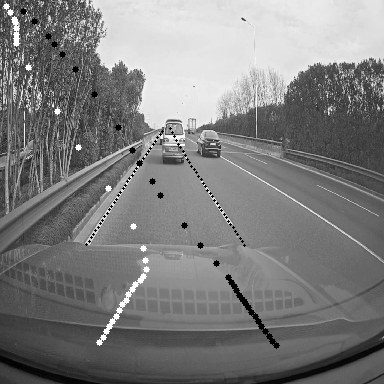

1000/1000 - 271s - loss: 2014.1964 - polyline_output_loss: 2013.4498 - label_output_1_loss: 0.3615 - label_output_2_loss: 0.3863 - polyline_output_mean_squared_error: 2013.4498 - label_output_1_accuracy: 0.8482 - label_output_2_accuracy: 0.8440 - val_loss: 13441.8926 - val_polyline_output_loss: 13435.6250 - val_label_output_1_loss: 3.9257 - val_label_output_2_loss: 2.3382 - val_polyline_output_mean_squared_error: 13435.6250 - val_label_output_1_accuracy: 0.3930 - val_label_output_2_accuracy: 0.4730 - lr: 3.2768e-04 - 271s/epoch - 271ms/step
Epoch 7/10


KeyboardInterrupt: ignored

In [141]:
history = model.fit(train_generator,
                    epochs=10,
                    verbose=2,
                    validation_data=validation_generator,
                    callbacks=[
                        tensorboard_callback,
                        early_stop_polyline_callback,
                        reduce_lr_callback_depends_on_polyline_loss,
                        model_checkpoint_callback,
                        reduce_lr_callback_depends_on_label_1_loss,
                        reduce_lr_callback_depends_on_label_2_loss,
                        CustomCallback(train_generator=train_generator, validation_generator=validation_generator)
                      ],
                    )

In [161]:
from google.colab import files

In [151]:
model_name_download = MODEL_NAME + '.h5'

In [159]:
model_name_download

'fixed_coordinate_own_cnn_lane_line_recognition.h5'

In [162]:
model.save('my_model.h5') 

In [163]:
files.download('my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>